# imports and reading data

In [701]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [702]:
df = pd.read_csv(r"C:\Users\fr\Desktop\vs code\california_housing_with_my_brain\housing.csv")
df.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY


In [703]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [704]:
df.drop(["longitude", "latitude"], axis=1).describe()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


## some plots from features

![alt text](13e8d0bf-a6a7-4cf7-8be6-40380c3870dd-1.png)

![alt text](59f3eb17-5c5c-4282-88b6-be9b08d2e2e2.png)

as we see, the best feature is `median_income` for predicting target

# Data cleaning

## filling nulls

In [705]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [706]:
# # filling "total_bedrooms" nulls

# # method 1(by filling with mode or mean) :
# most_bedrooms = df["total_bedrooms"].mode()[0] # 280
# df["total_bedrooms"].fillna(most_bedrooms, inplace=True)

In [707]:
# method 2(by prediction) : 
from sklearn.neighbors import KNeighborsClassifier

train_data = df[df["total_bedrooms"].notnull()]
test_data = df[df["total_bedrooms"].isnull()]

X_train = train_data.drop(["total_bedrooms", "ocean_proximity", "latitude", "longitude", "housing_median_age", "median_income"], axis=1)
X_test = test_data.drop(["total_bedrooms", "ocean_proximity", "latitude", "longitude", "housing_median_age", "median_income"], axis=1)
y_train = train_data["total_bedrooms"]

bedrooms_predictor = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
bedrooms_predictor.fit(X_train, y_train)

prediction = bedrooms_predictor.predict(X_test)
df.loc[df["total_bedrooms"].isnull(), "total_bedrooms"] = prediction

In [708]:
df["total_bedrooms"].describe()

count    20640.000000
mean       536.486628
std        420.232562
min          1.000000
25%        295.000000
50%        434.000000
75%        645.000000
max       6445.000000
Name: total_bedrooms, dtype: float64

## detecting outliers

In [709]:
def OutlierDetection(column): # column must be a pandas.DataFrame
    Q1, Q3 = df[column].quantile(0.25), df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound, upper_bound = (Q1 - IQR * 1.5), (Q3 + IQR * 1.5)
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

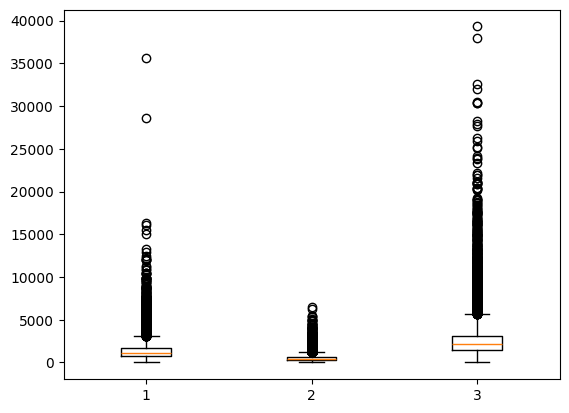

In [710]:
plt.boxplot(x = df[["population", "total_bedrooms", "total_rooms"]])
plt.show()

In [711]:
for dataframe in ["population", "total_bedrooms", "total_rooms"]:
    OutlierDetection(dataframe)

In [712]:
# plt.boxplot(x = df[["population", "total_bedrooms", "total_rooms"]])
# plt.show()

# playing with features

In [713]:
# new feature
df["total_non_bedrooms"] = df["total_rooms"] - df["total_bedrooms"]
df.drop(["total_rooms", "total_bedrooms"], axis=1, inplace=True)

<Axes: >

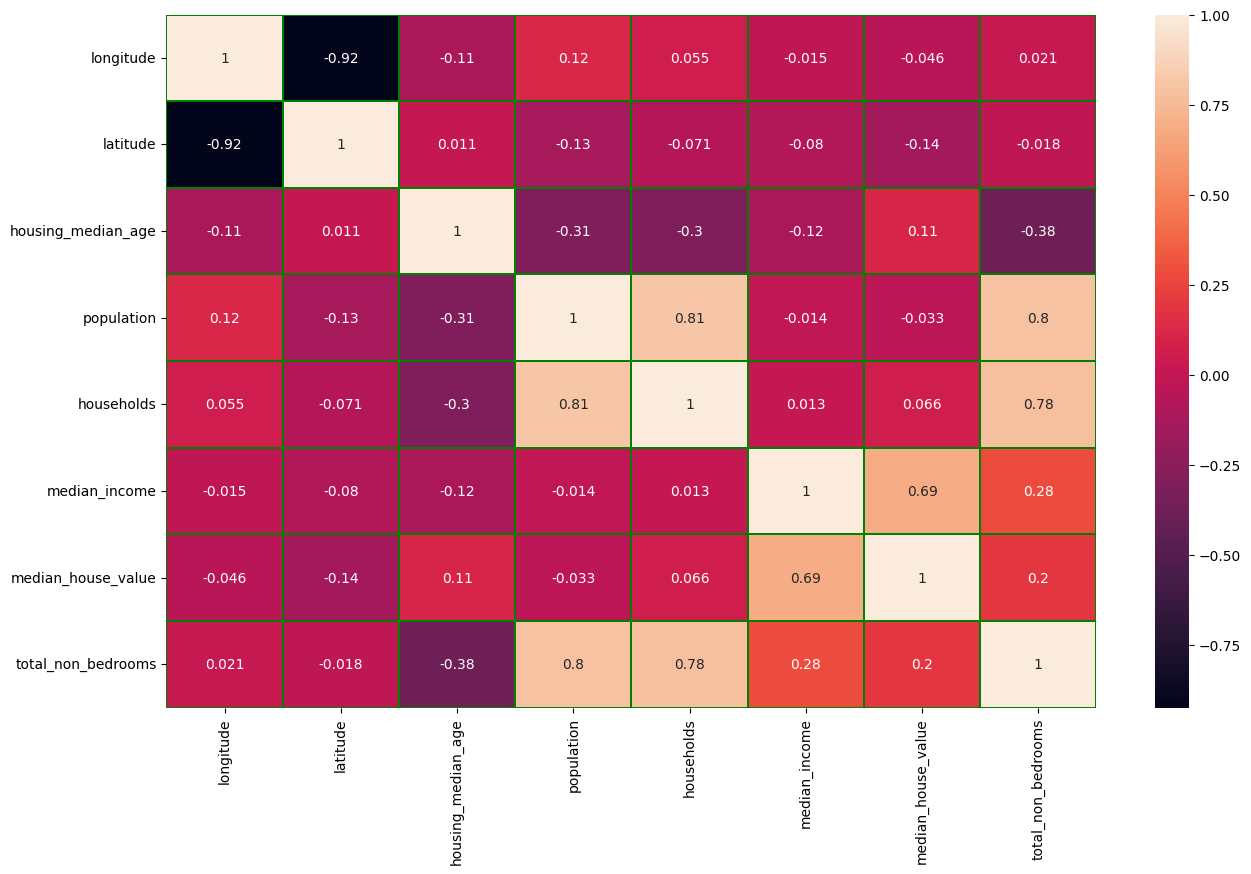

In [714]:
corr_mat = df.drop("ocean_proximity", axis=1).corr()

plt.figure(figsize=(15, 9))
sns.heatmap(data=corr_mat, linewidths=0.3, linecolor="green", annot=True)

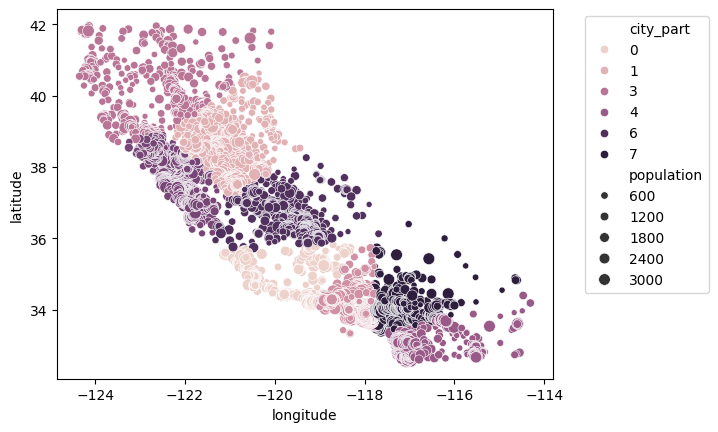

In [715]:
# adding features with k_means on "lat" and "long"
from sklearn.cluster import KMeans

coords = df[["longitude", "latitude"]]
kmeans = KMeans(n_clusters=8, random_state=56)
df["city_part"] = kmeans.fit_predict(coords)

sns.scatterplot(data=df, x="longitude", y="latitude", hue="city_part", size="population")
plt.legend(bbox_to_anchor=(1.05, 1))

In [716]:
df.drop(["longitude", "latitude"], axis=1, inplace=True)

# ML model

## preproccesing

In [717]:
df = df[df["median_house_value"] < 500001] # filtering with target

<Axes: >

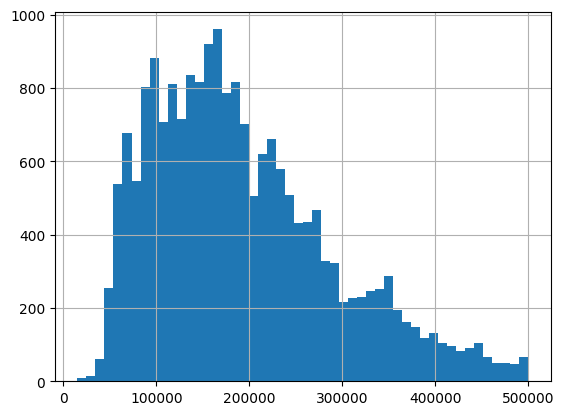

In [718]:
df["median_house_value"].hist(bins=50)

In [719]:
df = pd.concat((pd.get_dummies(df["ocean_proximity"]).astype(int), df.drop("ocean_proximity", axis=1)), axis=1)

In [720]:
df["value_ranges"] = pd.cut(x=df["median_house_value"],
                            bins=[0, 80000, 200000, 270000, 350000, np.inf],
                            labels=[1, 2, 3, 4, 5,])

In [721]:
from sklearn.model_selection import train_test_split

X = df.drop("median_house_value", axis=1)
y = df["median_house_value"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=df["value_ranges"], random_state=56, shuffle=True)
X_train.drop("value_ranges", axis=1, inplace=True)
X_test.drop("value_ranges", axis=1, inplace=True)

In [723]:
from sklearn.preprocessing import StandardScaler

scaler_X, scaler_y = StandardScaler(), StandardScaler() # dont scale y(s) in the real life!
X_train, X_test = scaler_X.fit_transform(X_train), scaler_X.transform(X_test)
y_train, y_test = scaler_y.fit_transform(np.array(y_train).reshape(-1, 1)), scaler_y.transform(np.array(y_test).reshape(-1, 1))
# y_train, y_test = scaler_y.fit_transform(y_train), scaler_y.transform(y_test)

## model with `cv` and `grid_search`

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

model = RandomForestRegressor(random_state=56, n_jobs=-1)
model.fit(X_train, y_train)
print(r2_score(y_test, model.predict(X_test)))
print(r2_score(y_train, model.predict(X_train)))

In [ ]:
from sklearn.model_selection import cross_val_score

output = cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1, scoring="r2")
pd.Series(output).describe()

In [ ]:
from sklearn.model_selection import GridSearchCV

params_grid = {"max_depth":[19, 35, 40], 
               "min_samples_leaf":[4, 6 ,8],
               "min_samples_split":[5, 10, 15]}

gs = GridSearchCV(estimator=model, param_grid=params_grid, scoring="r2", cv=3, n_jobs=-1)
gs.fit(X_train, y_train)
gs.best_params_

In [ ]:
gs.best_score_

## NeuralNetwork

In [728]:
import torch
import torch.nn as nn

In [729]:
from torch.utils.data import DataLoader, TensorDataset

X_train_tensor = torch.tensor(X_train, dtype=torch.float)
X_test_tensor = torch.tensor(X_test, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.float)
y_test_tensor = torch.tensor(y_test, dtype=torch.float)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)

In [734]:
class NeuralNetwork(nn.Module): # -> Regression
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 8)
        self.fc4 = nn.Linear(8, 1)

    def forward(self, z):
        z = torch.relu(self.fc1(z))
        z = torch.relu(self.fc2(z))
        z = torch.relu(self.fc3(z))
        z = self.fc4(z)

        return z

In [ ]:
model = NeuralNetwork(X_train.shape[1])
criterion = nn.MSELoss()

In [767]:
opt = torch.optim.SGD(params=model.parameters(), lr=0.0003)

In [768]:
for epochs in range(50):
    model.train()
    for X_batch, y_batch in train_loader:
        opt.zero_grad()
        y_pred = model(X_batch.cpu())
        loss = criterion(y_pred, y_batch.cpu())
        loss.backward()
        opt.step()

        with torch.no_grad():
            model.eval()
            print(f"loss : {np.sqrt(loss.item())}")

loss : 0.6350026788429765
loss : 0.5614170404889436
loss : 0.592597495399278
loss : 0.5311850059245157
loss : 0.6010633354534235
loss : 0.4751144986436063
loss : 0.528379905851181
loss : 0.47059661799916647
loss : 0.42141509595956306
loss : 0.43327287021351446
loss : 0.5626803744715646
loss : 0.5191951037109925
loss : 0.5150263229605698
loss : 0.7041666156911738
loss : 0.41543359292817095
loss : 0.5062998028971232
loss : 0.5266936356796067
loss : 0.417251702701164
loss : 0.514560264837386
loss : 0.41023072066211386
loss : 0.5778789254314518
loss : 0.42832374901878034
loss : 0.5186134491868731
loss : 0.5064074224442584
loss : 0.6852398481010182
loss : 0.5455912099121787
loss : 0.4414865370120154
loss : 0.5930672534853033
loss : 0.48033746616004935
loss : 0.4859978653680366
loss : 0.4939724028954181
loss : 0.5070226248314647
loss : 0.5721907843386665
loss : 0.4837980525968324
loss : 0.5653441632936521
loss : 0.526552836388905
loss : 0.5175187562685551
loss : 0.5934759059488841
loss : 0.4

In [769]:
from sklearn.metrics import r2_score

print(f"Train: {r2_score(y_train_tensor.detach().numpy(), model(X_train_tensor).detach().numpy())}")
print(f"Test: {r2_score(y_test_tensor.detach().numpy(), model(X_test_tensor).detach().numpy())}")

Train: 0.7247837781906128
Test: 0.7087429761886597
